## Convective area and MCS identification

In [12]:
import pyart
import cv2
import xarray
from scipy.ndimage import measurements
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-08-17 12:50:01.291000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [25]:
conv_strat_path = 'C://Users/rjackson/Documents/data/cpol_conv_strat200601200050.nc'
cpol_grid_path = 'C://Users/rjackson/Documents/data/CPOL_GRID.20060120.005008.100km.nc'

C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-08-17 12:58:35.527000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [8]:
cstrat_dset = xarray.open_dataset(conv_strat_path)
cstrat_dset

C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-08-17 12:43:03.659000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


<xarray.Dataset>
Dimensions:     (X: 201, Y: 201)
Dimensions without coordinates: X, Y
Data variables:
    Grid_X      (X) float32 ...
    Grid_Y      (Y) float32 ...
    strat_conv  (X, Y) int32 ...

C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-08-17 12:43:30.868000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


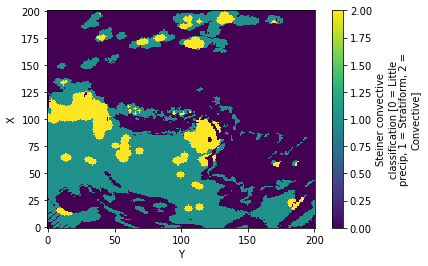

In [10]:
cstrat_dset.strat_conv.plot()

(201, 201)


C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-08-17 13:07:13.967000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


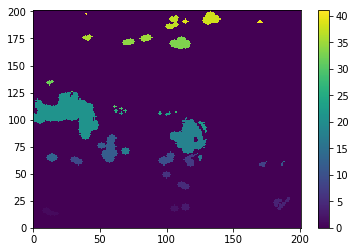

In [30]:
conv_regions = np.ma.masked_where(cstrat_dset.strat_conv.values < 2, cstrat_dset.strat_conv.values)
conv_regions[conv_regions.mask] = 0
labels = measurements.label(conv_regions)
print(labels[0].shape)
plt.pcolormesh(labels[0])
plt.colorbar()

In [31]:
areas = np.zeros(labels[0].max()-1)
ones_array = np.ones(labels[0].shape)
for i in range(1, labels[0].max()):
    areas[i-1] = np.sum(ones_array[labels[0] == i])
print(areas)

[5.600e+01 2.900e+01 2.900e+01 6.800e+01 5.000e+01 2.900e+01 6.100e+01
 1.500e+01 5.000e+01 9.000e+01 5.000e+00 2.230e+02 4.900e+01 1.000e+00
 1.000e+00 1.200e+01 2.900e+01 5.110e+02 1.000e+00 1.000e+00 1.076e+03
 2.800e+01 1.000e+01 5.000e+00 5.000e+00 5.000e+00 5.000e+00 1.000e+00
 5.000e+00 5.000e+00 1.000e+00 1.600e+01 1.260e+02 4.700e+01 4.800e+01
 3.000e+01 7.400e+01 1.080e+02 1.300e+01 9.000e+00]


C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-08-17 13:07:25.925000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-08-17 16:10:32.431000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\pyart\io\cfradial.py:376: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]
C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\pyart\io\cfradial.py:376: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  data = self.ncvar[:]


# of MCSs:1


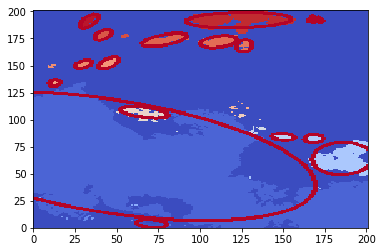

In [97]:
pyart_grid = pyart.io.read_grid(cpol_grid_path)
z = pyart_grid.fields['corrected_reflectivity']['data']
z_15km = z[2,:,:]
pfs = z_15km
pfs[z_15km < 15] = 0
pfs[z_15km >= 15] = 10
label_pfs = measurements.label(pfs) 
im = plt.pcolormesh(label_pfs[0], cmap='coolwarm')
ellipse_list = []
for the_labels in range(1, np.max(label_pfs[0])):
    img = np.where(label_pfs[0] == the_labels, np.ones(label_pfs[0].shape, dtype='uint8'), 
                  np.zeros(label_pfs[0].shape, dtype='uint8'))
    if(img.sum() > 30):
        ret,thresh = cv2.threshold(img,0.9,1.1,0)
        im2, contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        cnt = contours[0]
        ellipse = cv2.fitEllipse(cnt)
        ellipse_list.append(ellipse)
num_mcs = 0    
for ell in ellipse_list:
    cv2.ellipse(label_pfs[0],ell,(255,255,255),2)
    if(ell[1][0] > 100 or ell[1][1] > 100):
        num_mcs += 1
print('# of MCSs:' + str(num_mcs))

In [93]:
print(ell[])

((33.34320831298828, 190.89881896972656), (7.579987525939941, 15.954501152038574), 142.48788452148438)


C:\Users\rjackson\AppData\Local\Continuum\Anaconda2\envs\pyart-2018\lib\site-packages\jupyter_client\jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-08-17 16:04:07.701000. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
